Approximate sin(\pi * x) when the inputs are x and t. Additionally, enforce that \frac{du(t,x)}{dt} = 0.

Import Statements

In [132]:
import os
import torch
import torchvision
from torch import nn 
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset
import pyDOE2

Some Variables

In [133]:
n = 200 #num data points
n_collocation = 10000

Data Generation

In [134]:
np.random.seed(0)

#generate n random data points between -1 and 1

input_values = np.random.rand(n) * 2 - 1
input_values = np.column_stack((np.zeros(n), input_values)) #Add a second t dimension that is always 0 (of form t,x)

#labels of sin(\pi * x) for each x in Say
label_values = np.sin(input_values[:, 1] * np.pi)



Collocation Point Generation

In [135]:
def lhs_samples(n_collocation): #generate n_collocation points via Latin Hypercube Sampling. Each point is a (t,x)
    lhs_array = pyDOE2.lhs(2, samples=n_collocation) #Two dimensions. Values from 0 to 1
    lhs_array[:,1] = 2*lhs_array[:,1] - 1 #convert range of x values to -1 to 1
    return lhs_array

collocation_points = lhs_samples(n_collocation)

Neural Network

In [136]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_func = nn.Tanh()
        self.predict = nn.Sequential(
            nn.Linear(2, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 1)
        )

    def forward(self, x):
        x = self.predict(x)
        return x


PINN Loss

In [137]:
def derivLoss(network, collocation_t, collocation_x):

    u = network(torch.cat((collocation_t, collocation_x), dim=1))

    u_t = torch.autograd.grad(u, collocation_t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]

    return torch.mean(u_t**2)
    

    

def criterion(output, labels, network, collocation_t, collocation_x):
    loss_u = nn.MSELoss()(output, labels)
    loss_f = derivLoss(network, collocation_t, collocation_x)
    return loss_u + loss_f

Model Training Parameters

In [138]:
network = Network()
optimizer = torch.optim.Adam(network.parameters())

num_epochs = 500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + ("GPU" if torch.cuda.is_available() else "CPU"))
network.to(device)

input_data = torch.tensor(input_values.astype(np.float32)).to(device).view(-1, 2)
label_data = torch.tensor(label_values.astype(np.float32)).to(device).view(-1, 1)
collocation_t = torch.tensor(collocation_points[:,0].astype(np.float32), requires_grad=True).to(device).view(-1, 1)
collocation_x = torch.tensor(collocation_points[:,1].astype(np.float32), requires_grad=True).to(device).view(-1, 1)

Using device: CPU


Model Training

In [139]:
for epoch in range(num_epochs):

    output = network(input_data)
    loss = criterion(output, label_data, network, collocation_t, collocation_x)

    print(loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

0.5068793296813965
0.5016068816184998
0.4969446063041687
0.49290141463279724
0.48945730924606323
0.48654699325561523
0.4840543270111084
0.48180854320526123
0.47958481311798096
0.47712284326553345
0.47416332364082336
0.470481276512146
0.4659000039100647
0.4602874517440796
0.4535439610481262
0.4455919563770294
0.4363684356212616
0.42581847310066223
0.4138939380645752
0.4005576968193054
0.38578590750694275
0.3695567846298218
0.3518224358558655
0.3324904441833496
0.3114597499370575
0.28871220350265503
0.264415442943573
0.2389952689409256
0.21316295862197876
0.18789701163768768
0.16437451541423798
0.1438426673412323
0.12745600938796997
0.11615285277366638
0.11054110527038574
0.11056165397167206
0.11487417668104172
0.12068743258714676
0.12496425211429596
0.12604111433029175
0.12393976002931595
0.11957714706659317
0.11393339931964874
0.10770079493522644
0.10136330872774124
0.09536103904247284
0.0901091992855072
0.0859098732471466
0.08287700265645981
0.08093376457691193
0.07987063378095627
0.0

2d Graphing at t = 0 of Labels and Predictions

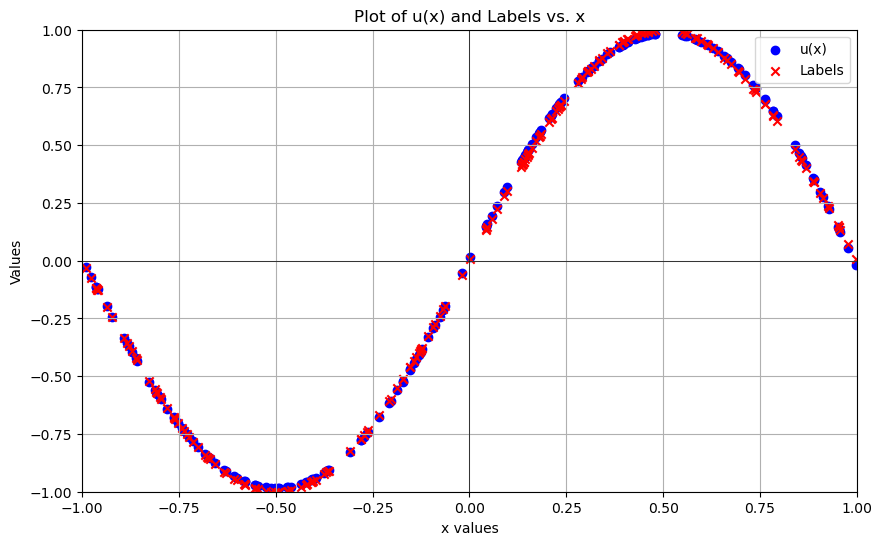

In [140]:
def plot_tensors(x, u, labels):
    # Convert tensors to numpy arrays
    x_np = x
    u_np = u

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_np, u_np, color='blue', marker='o', label='u(x)')
    
    if labels is not None:
        labels_np = labels
        plt.scatter(x_np, labels_np, color='red', marker='x', label='Labels')
    
    plt.title('Plot of u(x) and Labels vs. x')
    plt.xlabel('x values')
    plt.ylabel('Values')
    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.legend()
    plt.show()

# Example usage:
x = input_values[:, 1]
u = network(torch.Tensor(input_values.astype(np.float32)).view(-1,2)).detach().numpy()


plot_tensors(x, u, label_values)

2d Graphing at t = 0 of Random Points and Predictions

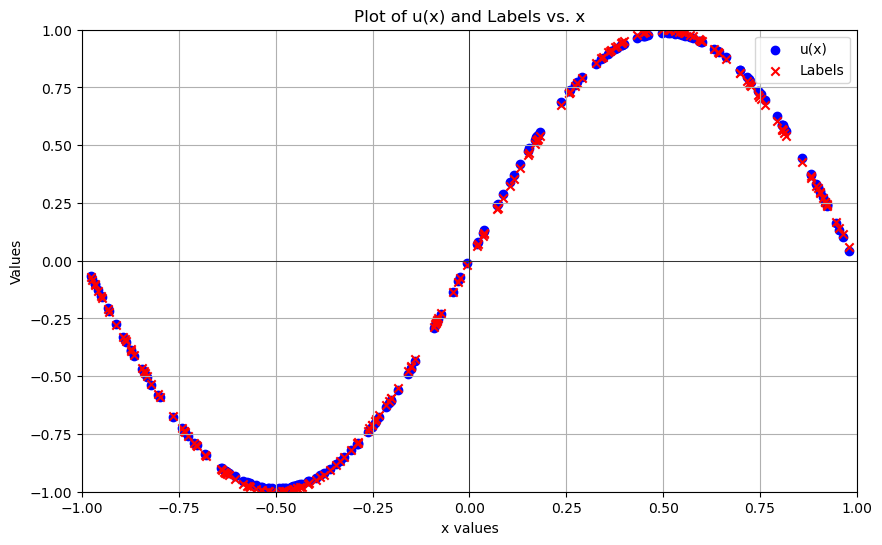

In [141]:
test_n = n

test_input_values = np.random.rand(test_n) * 2 - 1
test_input_values = np.column_stack((np.zeros(test_n), test_input_values)) #Add a second t dimension that is always 0

#labels of sin(\pi * x) for each x in Say
test_label_values = np.sin(test_input_values[:, 1] * np.pi)


def plot_tensors(x, u, labels):
    # Convert tensors to numpy arrays
    x_np = x
    u_np = u

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_np, u_np, color='blue', marker='o', label='u(x)')
    
    if labels is not None:
        labels_np = labels
        plt.scatter(x_np, labels_np, color='red', marker='x', label='Labels')
    
    plt.title('Plot of u(x) and Labels vs. x')
    plt.xlabel('x values')
    plt.ylabel('Values')
    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.legend()
    plt.show()

# Example usage:
x = test_input_values[:, 1]
u = network(torch.Tensor(test_input_values.astype(np.float32)).view(-1,2)).detach().numpy()


plot_tensors(x, u, test_label_values)

3d Graphing for -1 \leq x \leq 1 and 0 \leq t \leq 1

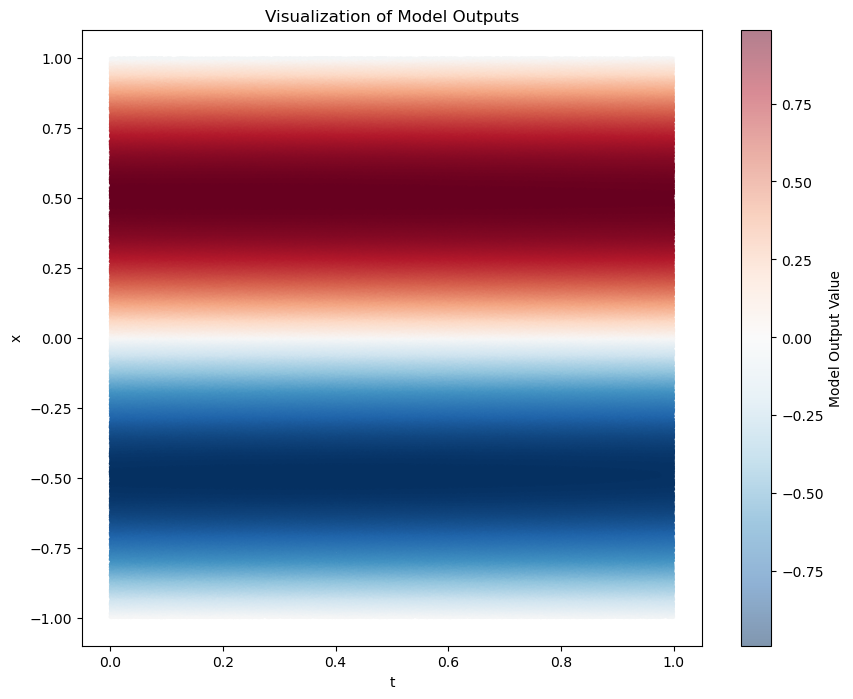

In [142]:
#Generate Random Points
num_points = 1000000
num_boundary_points = 0 #add some points just on t = 0
t_values = np.random.uniform(0, 1, num_points)
t_values = np.hstack((t_values, np.zeros(num_boundary_points)))
x_values = np.random.uniform(-1, 1, num_points + num_boundary_points)


points = np.vstack((t_values, x_values)).T
points_tensor = torch.tensor(points, dtype=torch.float32).to(device)



#Feed the Points through the Model
with torch.no_grad():
    model_outputs = network(points_tensor).cpu().numpy()
    #print(model_outputs)

#print(model_outputs[20:])
#print(points[20:, 0])


#Plotting
plt.figure(figsize=(10, 8))
plt.scatter(t_values, x_values, c=model_outputs.squeeze(), cmap='RdBu_r', s=1, alpha=0.5)
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(label='Model Output Value')
plt.title("Visualization of Model Outputs")
plt.show()
